In [1]:
import warnings
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 0

plt.rcParams.update({
    "font.size": 9,
    'figure.figsize': (15.0, 4.0),
})

np.set_printoptions(suppress=True)

warnings.filterwarnings('ignore')

# Scikit Learn:
- Lib para hacer Machine Learning
- Tanto los modelos en sí, como cosas típicas alrededor (métricas, preprocesado, etc)
- Muy modular: nos da bloques que nosotros enganchamos entre sí

# Pipeline, transformers & estimators

* **estimator**: un **modelo** de Machine Learning. Los métodos más importantes son:
    * fit(X, y): entrenar un modelo! **X** son los inputs *(matriz de n_samples x n_features)*, **y** son los outputs (si hace falta) *(array de n_samples)*
    * predict(X): generar outputs! **X** son los inputs *(matriz de n_samples x n_features)*. Devuelve las predicciones *(array de n_samples)*
    * Algunos también tienen predict_proba(X): igual que predict, pero nos da la probabilidad en vez de la clase final.
    
* **Transformers** y **pre-processors**: Son objetos para aplicar transformaciones y preprocesamientos (standarización, imputación de nulos, one-hot y otros encoders, etc..) antes de entrenar un modelo. Los métodos más importantes son:
    * fit(X, y): idem al fit de un estimador
    * transform(X): Devuelve una matriz de *n_samples x n_features_new*, donde n_features_new depende mucho de la transformación que hagamos
    
    https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
    
    
* **Pipeline**: Es un objeto que permite encadenar uno o más transformers, y opcionalmente un estimador final. Sigue la misma interfaz que un estimador.

* **Feature Union**: En un objeto que permite *concatenar* (horizontalmente) las salidas de uno o mas transformers.

![](images/pipeline.svg)
    

# Ejemplos super básicos:

### Estimator (modelo)

In [5]:
from sklearn.linear_model import LogisticRegression

In [2]:
# ej: edad, clase, precio ticket
entradas = np.array((
    (20, 1, 200),
    (10, 1, 90),
    (30, 3, 200),
    (10, 2, 150),
    (20, 2, 70),
))

# ej: sobrevive o no
salidas = np.array((
    0,
    1,
    0,
    0,
    1,
))

In [3]:
entradas

array([[ 20,   1, 200],
       [ 10,   1,  90],
       [ 30,   3, 200],
       [ 10,   2, 150],
       [ 20,   2,  70]])

In [4]:
salidas

array([0, 1, 0, 0, 1])

In [6]:
modelo = LogisticRegression()
modelo.fit(entradas, salidas)

LogisticRegression()

In [7]:
# nuevos casos
modelo.predict((
    (10, 3, 150),
    (10, 3, 50),
    (20, 2, 250),
))

array([0, 1, 0])

In [8]:
# nuevos casos
modelo.predict_proba((
    (10, 3, 150),
    (10, 3, 50),
    (20, 2, 250),
))

array([[0.99683564, 0.00316436],
       [0.00000145, 0.99999855],
       [1.        , 0.        ]])

In [9]:
modelo.coef_, modelo.intercept_
# (recordar que al no estr normalizadas las entradas, esto no tiene tanto sentido verlo)

(array([[ 0.00066217, -0.00311447, -0.19194013]]), array([23.04110668]))

### Transformer

![](images/transformer.jpg)

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
entradas = np.array((
    ("avion", "blanco"),
    ("perro", "blanco"),
    ("perro", "amarillo"),
    ("loro", "verde"),
    ("avion", "verde"),
))

In [12]:
transformer = OneHotEncoder()
transformer.fit(entradas)

OneHotEncoder()

In [13]:
transformer.get_feature_names_out()

array(['x0_avion', 'x0_loro', 'x0_perro', 'x1_amarillo', 'x1_blanco',
       'x1_verde'], dtype=object)

In [16]:
transformer.transform((
    ("loro", "blanco"),
    ("avion", "amarillo"),
    ("avion", "verde"),
)).todense()

matrix([[0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1.]])

### Pipeline

In [17]:
from sklearn.pipeline import Pipeline

In [19]:
entradas = np.array((
    ("avion", "blanco"),
    ("perro", "blanco"),
    ("perro", "amarillo"),
    ("loro", "verde"),
    ("avion", "verde"),
))

# es maquina o no
salidas = np.array((
    1,
    0,
    0,
    0,
    1,
))

In [20]:
pipe = Pipeline((
    ('encoder', OneHotEncoder()),
    ('predictor', LogisticRegression()),
))

pipe.fit(entradas, salidas)

Pipeline(steps=[('encoder', OneHotEncoder()),
                ('predictor', LogisticRegression())])

In [21]:
pipe.predict((
    ("loro", "blanco"),
    ("avion", "amarillo"),
    ("avion", "verde"),
))

array([0, 1, 1])

In [25]:
pipe.named_steps["predictor"].coef_

array([[ 0.81681398, -0.3157581 , -0.50078208, -0.21843502,  0.12279279,
         0.09591604]])

In [26]:
pipe.named_steps["encoder"].get_feature_names_out()

array(['x0_avion', 'x0_loro', 'x0_perro', 'x1_amarillo', 'x1_blanco',
       'x1_verde'], dtype=object)

# Ahora un ejemplo en serio: Titanic

# Leyendo los datos

In [27]:
!head ./titanic/train.csv

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S


In [28]:
all_data = pd.read_csv('./titanic/train.csv')

BETTER_COLUMN_NAMES = {
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'ticket_class',
    'Name': 'name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'siblings_spouses',
    'Parch': 'parents_children',
    'Ticket': 'ticket',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked_at',
    'Survived': 'survived',
}
all_data.rename(columns=BETTER_COLUMN_NAMES, inplace=True)

all_data.set_index('passenger_id', inplace=True)

all_data

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


#### Distribución de valores nulos

In [29]:
all_data.isnull().sum()

survived              0
ticket_class          0
name                  0
sex                   0
age                 177
siblings_spouses      0
parents_children      0
ticket                0
fare                  0
cabin               687
embarked_at           2
dtype: int64

### La columna a predecir es:

- survived

### Vamos a usar como entradas:

- sex: male/female
- age: numbers, many NaNs
- siblings_spouses: numbers, no NaNs
- parents_children: numbers, no NaNs
- ticket_class: 1/2/3
- fare: numbers, no NaNs
- embarked_at: C/Q/S and very few NaNs

### No vamos a utilizar:

- passenger_id: this could only lead to overfitting
- name: this has a high change of leading to overfitting
- cabin: very little data, and maybe able to overfit? are these single family/person rooms?

#### Como *embarket_at* tiene muy pocos nulos, directamente vamos a descartar los casos.

In [31]:
all_data = all_data[~all_data.embarked_at.isnull()]
all_data.shape

(889, 11)

## Conjuntos de datos

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((533, 11), (178, 11), (178, 11))

Podríamos armar el pipeline con transformers a mano a partir de cada columna de nuestro dataset, feature unions, etc. O...

# DataFrame Mapper

Nos facilita la integración de Pandas con sklearn. Nos arma automáticamente un pileline con transformers para cada columna del dataframe, y un feature union al final.

Funciona como un transformer.

![](images/dataframe_mapper.svg)



## Preparando el mapper

In [34]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [35]:
# Una primer version...
# Definimos el mapper. Recibe una lista de (columna/s, transformers)
mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()])
])

# Lo entrenamos con train
mapper.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['age'], [StandardScaler()]),
                          (['sex'], [OneHotEncoder()])])

In [36]:
# vemos como transforma un sample:
sample = train.sample(5, random_state=42)

# Sample original:
sample

,survived,ticket_class,name,sex,age,siblings_spouses,parents_children,ticket,fare,cabin,embarked_at
passenger_id,,,,,,,,,,,
106,0,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S
784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.4500,NaN,S
280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S
688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S
704,0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q


In [37]:
# Sample transformado
mapper.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [        nan,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

In [38]:
# Nombres de los faetures
mapper.transformed_names_

['age', 'sex_0', 'sex_1']

### Y los nulos???

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute

In [40]:
from sklearn.experimental import enable_iterative_imputer  # en versiones nuevas no va a hacer más falta
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [41]:
mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()])
])

In [42]:
pipe1 = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
])
# Lo entrenamos con train
pipe1.fit(train)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['age'], [StandardScaler()]),
                                           (['sex'], [OneHotEncoder()])])),
                ('imputer', SimpleImputer())])

In [43]:
pipe1.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [-0.        ,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

In [44]:
pipe2 = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
])
# Lo entrenamos con train
pipe2.fit(train)

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['age'], [StandardScaler()]),
                                           (['sex'], [OneHotEncoder()])])),
                ('imputer', IterativeImputer(random_state=42))])

In [45]:
# Sample transformado con mean
pipe1.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [-0.        ,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

In [46]:
# Sample transformado con Iterative
pipe2.transform(sample)

array([[-0.11193044,  0.        ,  1.        ],
       [ 0.00654025,  0.        ,  1.        ],
       [ 0.36886349,  1.        ,  0.        ],
       [-0.73009407,  0.        ,  1.        ],
       [-0.31798499,  0.        ,  1.        ]])

### El mapper completo

In [48]:
complete_mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['siblings_spouses'], [StandardScaler()]),
    (['parents_children'], [StandardScaler()]),
    (['ticket_class'], [StandardScaler()]),
    (['fare'], [StandardScaler()]),
    (['sex'], [OneHotEncoder()]),
    (['embarked_at'], [OneHotEncoder()]),
])

complete_mapper.fit(train)

# Sample transformado con el mapper completo
complete_mapper.transform(sample)

array([[-0.11193044, -0.49121516, -0.49013792,  0.79054795, -0.47297166,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [        nan,  0.42104157,  1.84239343,  0.79054795, -0.18341222,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.36886349,  0.42104157,  0.67612775,  0.79054795, -0.24298392,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [-0.73009407, -0.49121516, -0.49013792,  0.79054795, -0.4306199 ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ],
       [-0.31798499, -0.49121516, -0.49013792,  0.79054795, -0.4758404 ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ]])

In [49]:
complete_mapper.transformed_names_

['age',
 'siblings_spouses',
 'parents_children',
 'ticket_class',
 'fare',
 'sex_0',
 'sex_1',
 'embarked_at_0',
 'embarked_at_1',
 'embarked_at_2']

# Primer modelo: Regresión logística

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
lr_model_si = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_si.fit(train, train.survived)

y_pred = lr_model_si.predict(validation)

y_pred

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1])

#### Evaluamos con métricas: sklearn.metrics

Muchas funciones listas para evaluar modelos:

https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [52]:
from sklearn import metrics

In [53]:
metrics.accuracy_score(validation.survived, y_pred)

0.8089887640449438

In [54]:
metrics.precision_score(validation.survived, y_pred)

0.7397260273972602

In [55]:
metrics.recall_score(validation.survived, y_pred)

0.782608695652174

In [56]:
print(metrics.classification_report(validation.survived, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       109
           1       0.74      0.78      0.76        69

    accuracy                           0.81       178
   macro avg       0.80      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



#### Programemos una función para evaluar un modelo...

In [57]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=False):
    if title:
        display(title)
        
    final_metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],        
    }
        
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.survived
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            cm = metrics.confusion_matrix(y, y_pred)
            cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, 
                                                     display_labels=['died', 'survived'])
            cm_plot.plot(cmap="Blues")
            cm_plot.ax_.set_title(set_name)
        
    display(pd.DataFrame(final_metrics, index=set_names))

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
validation,0.808989,0.739726,0.782609,0.760563


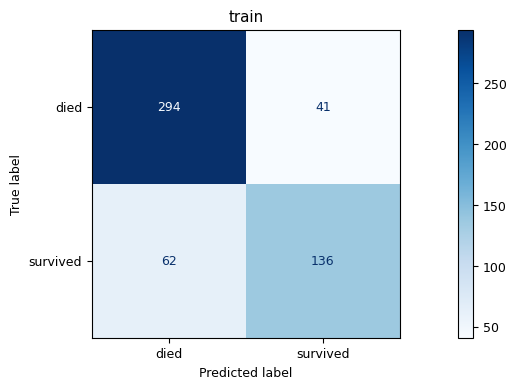

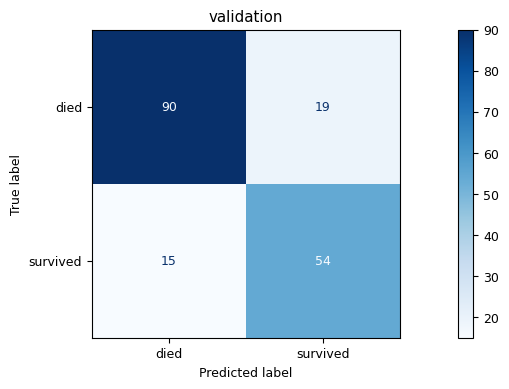

In [58]:
evaluate_model(lr_model_si, title='LR Simple Imputer', show_cm=True)

### Podemos inspeccionar un poco el modelo

In [59]:
lr_model_si

Pipeline(steps=[('mapper',
                 DataFrameMapper(drop_cols=[],
                                 features=[(['age'], [StandardScaler()]),
                                           (['siblings_spouses'],
                                            [StandardScaler()]),
                                           (['parents_children'],
                                            [StandardScaler()]),
                                           (['ticket_class'],
                                            [StandardScaler()]),
                                           (['fare'], [StandardScaler()]),
                                           (['sex'], [OneHotEncoder()]),
                                           (['embarked_at'],
                                            [OneHotEncoder()])])),
                ('imputer', SimpleImputer()),
                ('classifier', LogisticRegression(random_state=42))])

In [60]:
clf = lr_model_si.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística!

array([[-0.64913011, -0.42032152, -0.03878576, -0.91636464,  0.04911843,
         1.31154632, -1.38204573,  0.41207242, -0.20118266, -0.28138917]])

In [61]:
complete_mapper.transformed_names_

['age',
 'siblings_spouses',
 'parents_children',
 'ticket_class',
 'fare',
 'sex_0',
 'sex_1',
 'embarked_at_0',
 'embarked_at_1',
 'embarked_at_2']

<Axes: >

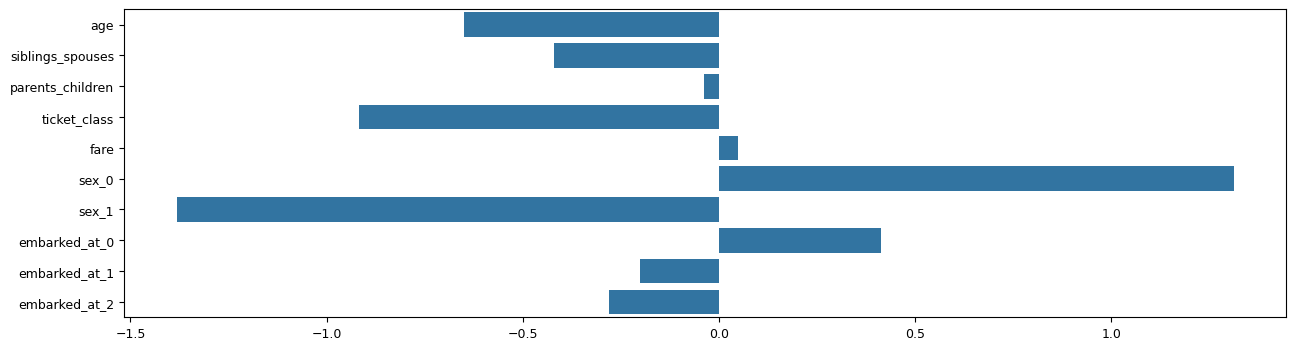

In [62]:
sns.barplot(
    x=clf.coef_[0],
    y=complete_mapper.transformed_names_,
)

un poco más ordenado, usando un dataframe para ordenar esa data...

<Axes: xlabel='coeficiente', ylabel='feature'>

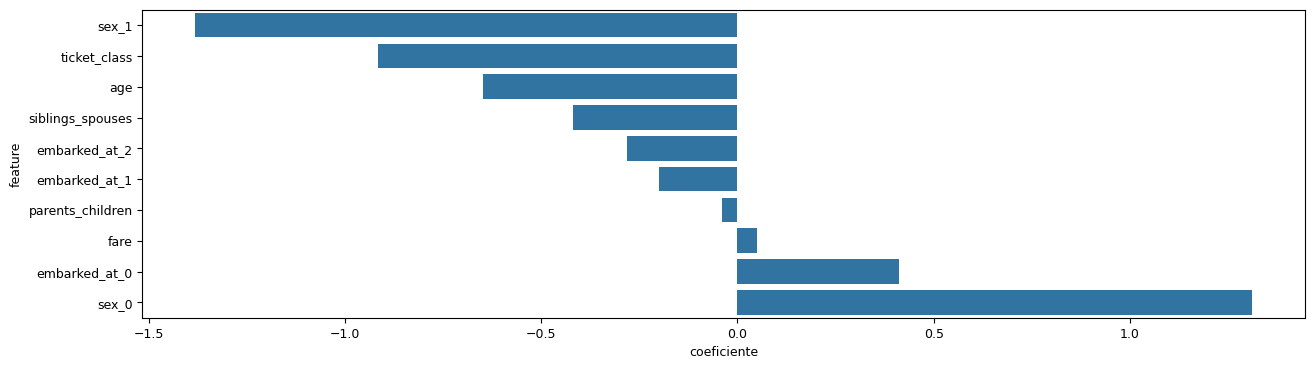

In [63]:
df_importance = pd.DataFrame({
    'feature': complete_mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

sns.barplot(data=df_importance, x='coeficiente', y='feature')

In [64]:
lr_model_ii = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model_ii.fit(train, train.survived)

evaluate_model(lr_model_ii, title='LR Iterative Imputer')

evaluate_model(lr_model_si, title='LR Simple Imputer')

'LR Iterative Imputer'

,Accuracy,Precision,Recall,F1
train,0.808630,0.769663,0.691919,0.728723
validation,0.825843,0.771429,0.782609,0.776978


'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
validation,0.808989,0.739726,0.782609,0.760563


# Segundo modelo: K nearest neighbors

In [65]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.838649,0.858974,0.676768,0.757062
validation,0.825843,0.806452,0.724638,0.763359


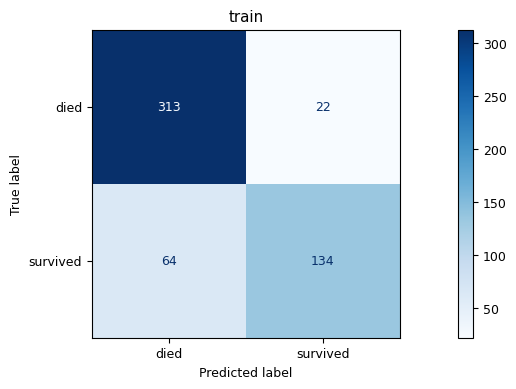

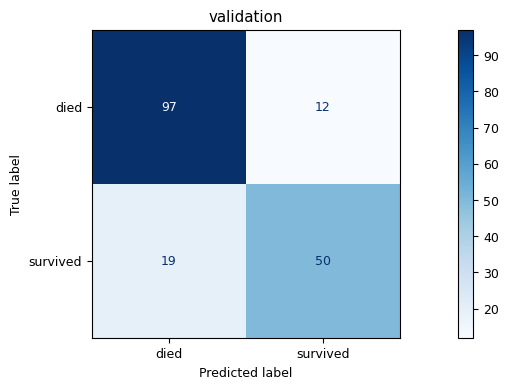

In [70]:
K = 10

knn_model = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

knn_model.fit(train, train.survived)

evaluate_model(knn_model, title='Knn', show_cm=True)

In [ ]:
knn_model.predict(validation)

In [ ]:
knn_model.predict_proba(validation)

# Tercer modelo: Arboles de decisión

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

In [79]:
label_binarizer_mapper = DataFrameMapper([
    (['age'], [StandardScaler()]),
    (['siblings_spouses'], [StandardScaler()]),
    (['parents_children'], [StandardScaler()]),
    (['ticket_class'], [StandardScaler()]),
    (['fare'], [StandardScaler()]),
    (['sex'], [LabelBinarizer()]),
    (['embarked_at'], [OneHotEncoder()]),
])

In [80]:
tree_model = DecisionTreeClassifier(random_state=42)

dt_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model),
])

dt_model.fit(train, train.survived)

evaluate_model(dt_model, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.988743,0.994845,0.974747,0.984694
validation,0.752809,0.671233,0.710145,0.690141


In [81]:
tree_model_limit = DecisionTreeClassifier(max_depth=3, random_state=42)

dt_model_limit = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model_limit),
])

dt_model_limit.fit(train, train.survived)

evaluate_model(dt_model_limit, title='Decision Tree with depth limit')

'Decision Tree with depth limit'

,Accuracy,Precision,Recall,F1
train,0.833021,0.826347,0.696970,0.756164
validation,0.792135,0.742424,0.710145,0.725926


In [82]:
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['died', 'survived'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

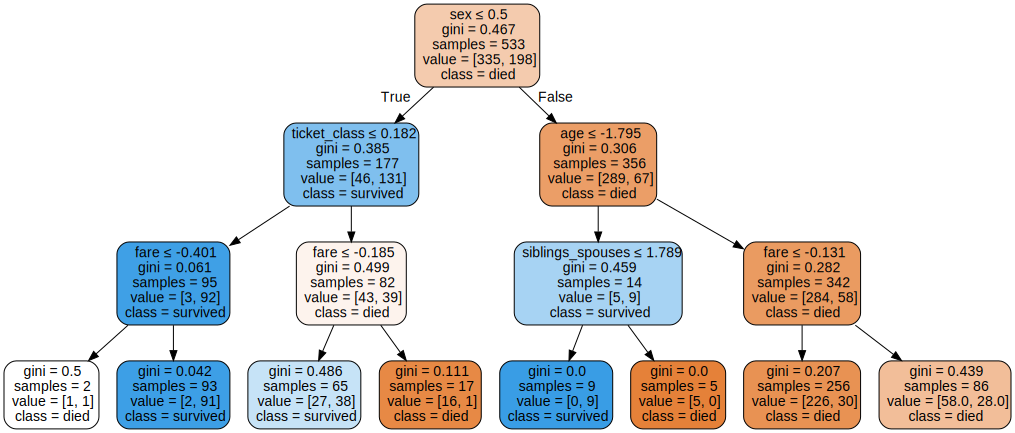

In [83]:
graph_tree(tree_model_limit, label_binarizer_mapper.transformed_names_)

# Cuarto modelo: Random Forests

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
forest_model = RandomForestClassifier(random_state=42)
# n_estimators? max_depth=3?, max_features=2?

rf_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.survived)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.988743,0.989796,0.979798,0.984772
validation,0.792135,0.728571,0.739130,0.733813


In [87]:
forest_model_limits = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=2, random_state=42)

rf_model_limits = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_limits),
])

rf_model_limits.fit(train, train.survived)

evaluate_model(rf_model_limits, title='Random Forest with limits')

'Random Forest with limits'

,Accuracy,Precision,Recall,F1
train,0.833021,0.909774,0.611111,0.731118
validation,0.820225,0.877551,0.623188,0.728814


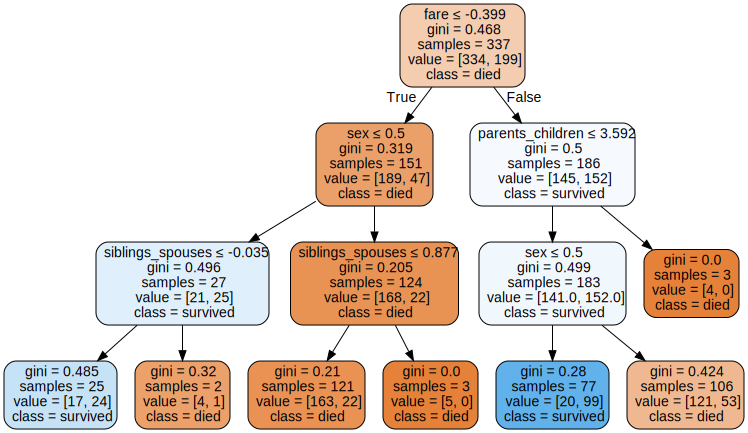

In [90]:
graph_tree(forest_model_limits.estimators_[2], col_names=label_binarizer_mapper.transformed_names_)

# Bonus: Grid Search

In [71]:
from sklearn.model_selection import GridSearchCV

In [77]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
parameters = {'n_neighbors': [1, 3, 5, 10, 15, 20, 50, 100]}

clf = GridSearchCV(knn_clf, parameters, refit=True, verbose=1)

gs_pipe = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train, train.survived)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


(0.7973549638511727, {'n_neighbors': 3})

In [ ]:
evaluate_model(gs_pipe, title='Knn from Grid Search')

In [91]:
parameters = {'n_estimators': [100, 200], 
              'max_depth':[3, 5, 8],
              'max_features': [2, 5]}

clf = GridSearchCV(forest_model, parameters, refit=True, verbose=1)

gs_pipe = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

gs_pipe.fit(train, train.survived)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


(0.8461470640098747, {'max_depth': 5, 'max_features': 5, 'n_estimators': 100})

In [ ]:
evaluate_model(gs_pipe, title='Random Forest from Grid Search')

# Bonus: Features polinomicas en LR

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
lr_model_pf = Pipeline([
    ('mapper', complete_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', LogisticRegression(max_iter=3000, random_state=42)),
])

lr_model_pf.fit(train, train.survived)

evaluate_model(lr_model_pf, title='LR with polynomic features')

evaluate_model(lr_model_ii, title='LR with normal features')

# El mejor modelo...


Es accuracy la mejor métrica?


In [92]:
evaluate_model(lr_model_si, title='LR Simple Imputer')
evaluate_model(lr_model_ii, title='LR Iterative Imputer')
#evaluate_model(lr_model_pf, title='LR with polynomic features')
evaluate_model(knn_model, title='Knn')
evaluate_model(dt_model, title='Decision Tree')
evaluate_model(dt_model_limit, title='Decision Tree with depth limit')
evaluate_model(rf_model, title='Random Forest')
evaluate_model(rf_model_limits, title='Random Forest with limits')
evaluate_model(gs_pipe, title='Random Forest from Grid Search')

'LR Simple Imputer'

,Accuracy,Precision,Recall,F1
train,0.806754,0.768362,0.686869,0.725333
validation,0.808989,0.739726,0.782609,0.760563


'LR Iterative Imputer'

,Accuracy,Precision,Recall,F1
train,0.808630,0.769663,0.691919,0.728723
validation,0.825843,0.771429,0.782609,0.776978


'Knn'

,Accuracy,Precision,Recall,F1
train,0.838649,0.858974,0.676768,0.757062
validation,0.825843,0.806452,0.724638,0.763359


'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.988743,0.994845,0.974747,0.984694
validation,0.752809,0.671233,0.710145,0.690141


'Decision Tree with depth limit'

,Accuracy,Precision,Recall,F1
train,0.833021,0.826347,0.696970,0.756164
validation,0.792135,0.742424,0.710145,0.725926


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.988743,0.989796,0.979798,0.984772
validation,0.792135,0.728571,0.739130,0.733813


'Random Forest with limits'

,Accuracy,Precision,Recall,F1
train,0.833021,0.909774,0.611111,0.731118
validation,0.820225,0.877551,0.623188,0.728814


'Random Forest from Grid Search'

,Accuracy,Precision,Recall,F1
train,0.879925,0.929487,0.732323,0.819209
validation,0.825843,0.816667,0.710145,0.759690


'Chosen model'

,Accuracy,Precision,Recall,F1
train,0.879925,0.929487,0.732323,0.819209
validation,0.825843,0.816667,0.710145,0.759690
test,0.792135,0.846154,0.602740,0.704000


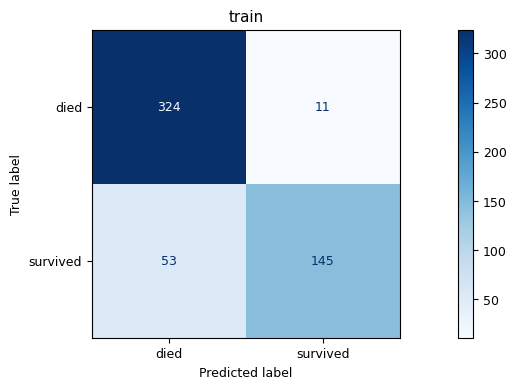

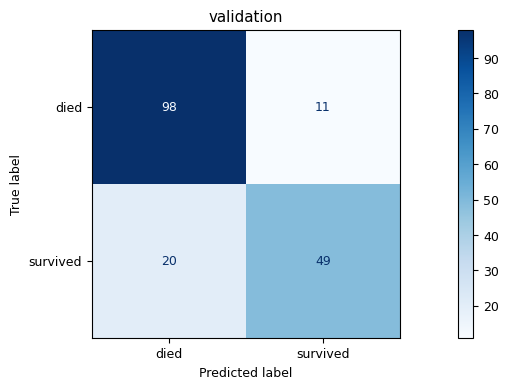

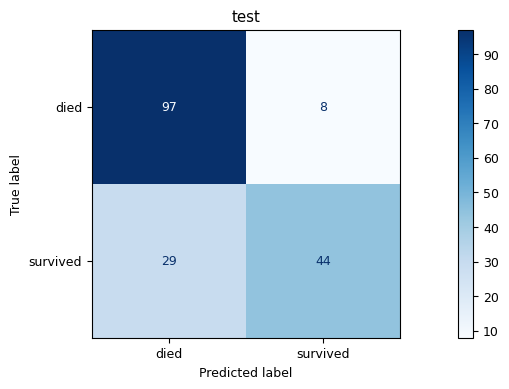

In [93]:
chosen_model = gs_pipe 
evaluate_model(chosen_model, title='Chosen model', set_names=('train', 'validation', 'test'), show_cm=True)

# Actividad: 
- Cargar el dataset del iris
- Separar en train, validation y test
- Armar un mapper básico
- Armar un pipeline para entrenar una regresión logística, entrenar y evaluar su accuracy en train y validation
- Armar un pipeline para entrenar un K vecinos más cercanos, entrenar y evaluar su accuracy en train y validation
- Elegir el modelo que mejor haya funcionado, y evaluar su accuracy en el dataset de test
- Pueden usar esta celda como template para arrancar en https://colab.research.google.com/ , que ya les levanta el dataset con pandas:

In [94]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
